In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.feature_selection import mutual_info_classif


In [3]:
# Load the data
try:
    data = pd.read_csv('dataset/KDDTest.txt', header=None)
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")
    exit(1)
except Exception as e:
    print(f"An error occurred while loading the data: {str(e)}")
    exit(1)

In [5]:
# Define columns based on provided structure
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]
data.columns = columns

In [6]:
# Convert categorical columns to numerical using LabelEncoder
label_encoders = {}
for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [7]:
# Binary classification for 'attack' column: 'normal' as 0 and others as 1
data['attack'] = data['attack'].apply(lambda x: 0 if x == 'normal' else 1)

In [8]:
# Split features and target
X = data.drop(['attack'], axis=1)
y = data['attack']

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# KNN Classifier with GridSearchCV
param_grid = {'n_neighbors': [4000, 5000, 6000], 'weights': ['uniform', 'distance']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=2, cv=3, refit=True)
grid.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ..................n_neighbors=4000, weights=uniform; total time=   3.2s
[CV] END ..................n_neighbors=4000, weights=uniform; total time=   3.0s
[CV] END ..................n_neighbors=4000, weights=uniform; total time=   2.8s
[CV] END .................n_neighbors=4000, weights=distance; total time=   2.9s
[CV] END .................n_neighbors=4000, weights=distance; total time=   3.0s
[CV] END .................n_neighbors=4000, weights=distance; total time=   2.8s
[CV] END ..................n_neighbors=5000, weights=uniform; total time=   2.8s
[CV] END ..................n_neighbors=5000, weights=uniform; total time=   2.8s
[CV] END ..................n_neighbors=5000, weights=uniform; total time=   2.8s
[CV] END .................n_neighbors=5000, weights=distance; total time=   3.3s
[CV] END .................n_neighbors=5000, weights=distance; total time=   3.5s
[CV] END .................n_neighbors=5000, weigh

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4000, 5000, 6000],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [13]:
# Best model from GridSearchCV
knn = grid.best_estimator_
y_pred = knn.predict(X_test)


In [14]:
# Evaluation
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Best Parameters: {'n_neighbors': 4000, 'weights': 'distance'}
Accuracy: 0.8533412182140745
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.85      2922
           1       0.98      0.76      0.85      3842

    accuracy                           0.85      6764
   macro avg       0.87      0.87      0.85      6764
weighted avg       0.88      0.85      0.85      6764

Confusion Matrix:
 [[2849   73]
 [ 919 2923]]
ROC AUC: 0.8679093886832412


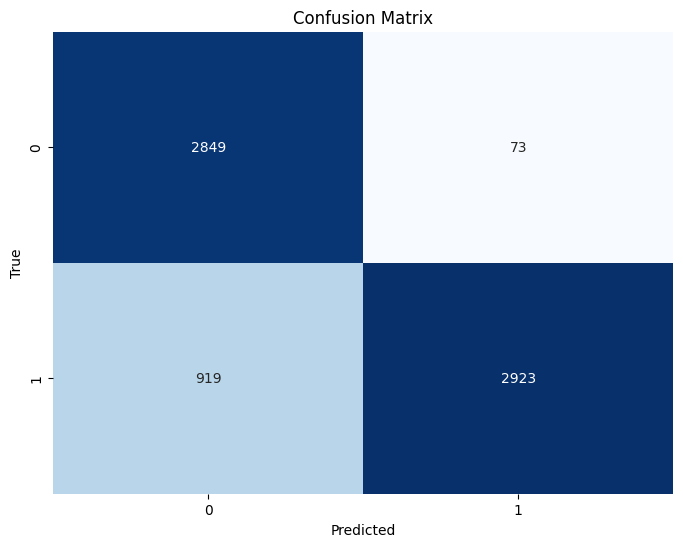

In [15]:
# Confusion Matrix with annotations
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


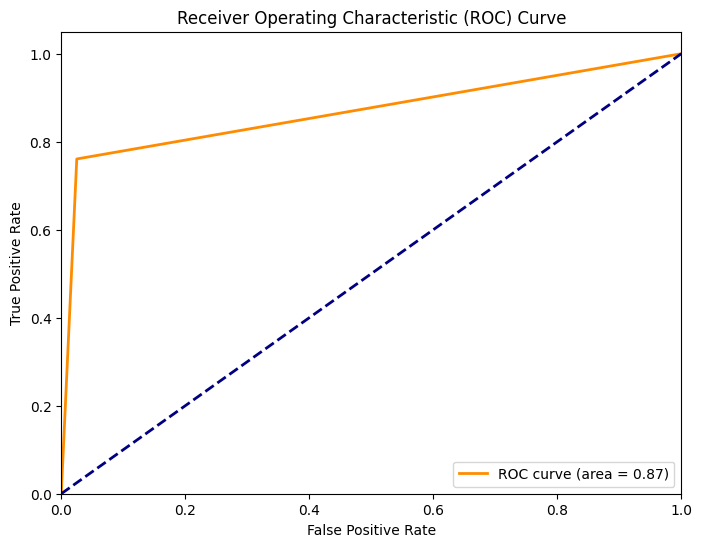

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

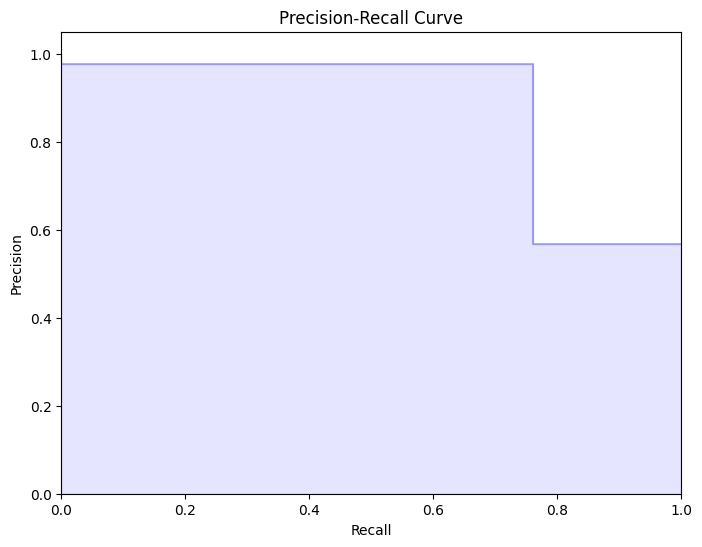

In [17]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.3, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.1, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

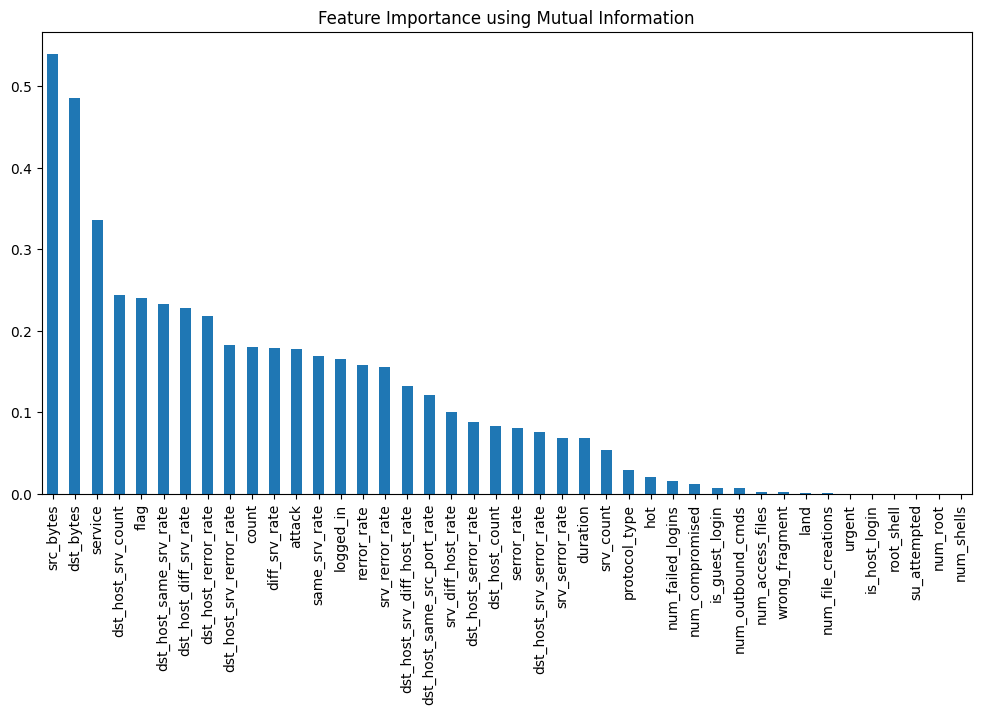

In [18]:
# Feature Importance using Mutual Information
mutual_info = mutual_info_classif(X, y)
mutual_info_series = pd.Series(mutual_info, index=columns[:-1])
mutual_info_series.sort_values(ascending=False).plot.bar(figsize=(12, 6))
plt.title('Feature Importance using Mutual Information')
plt.show()


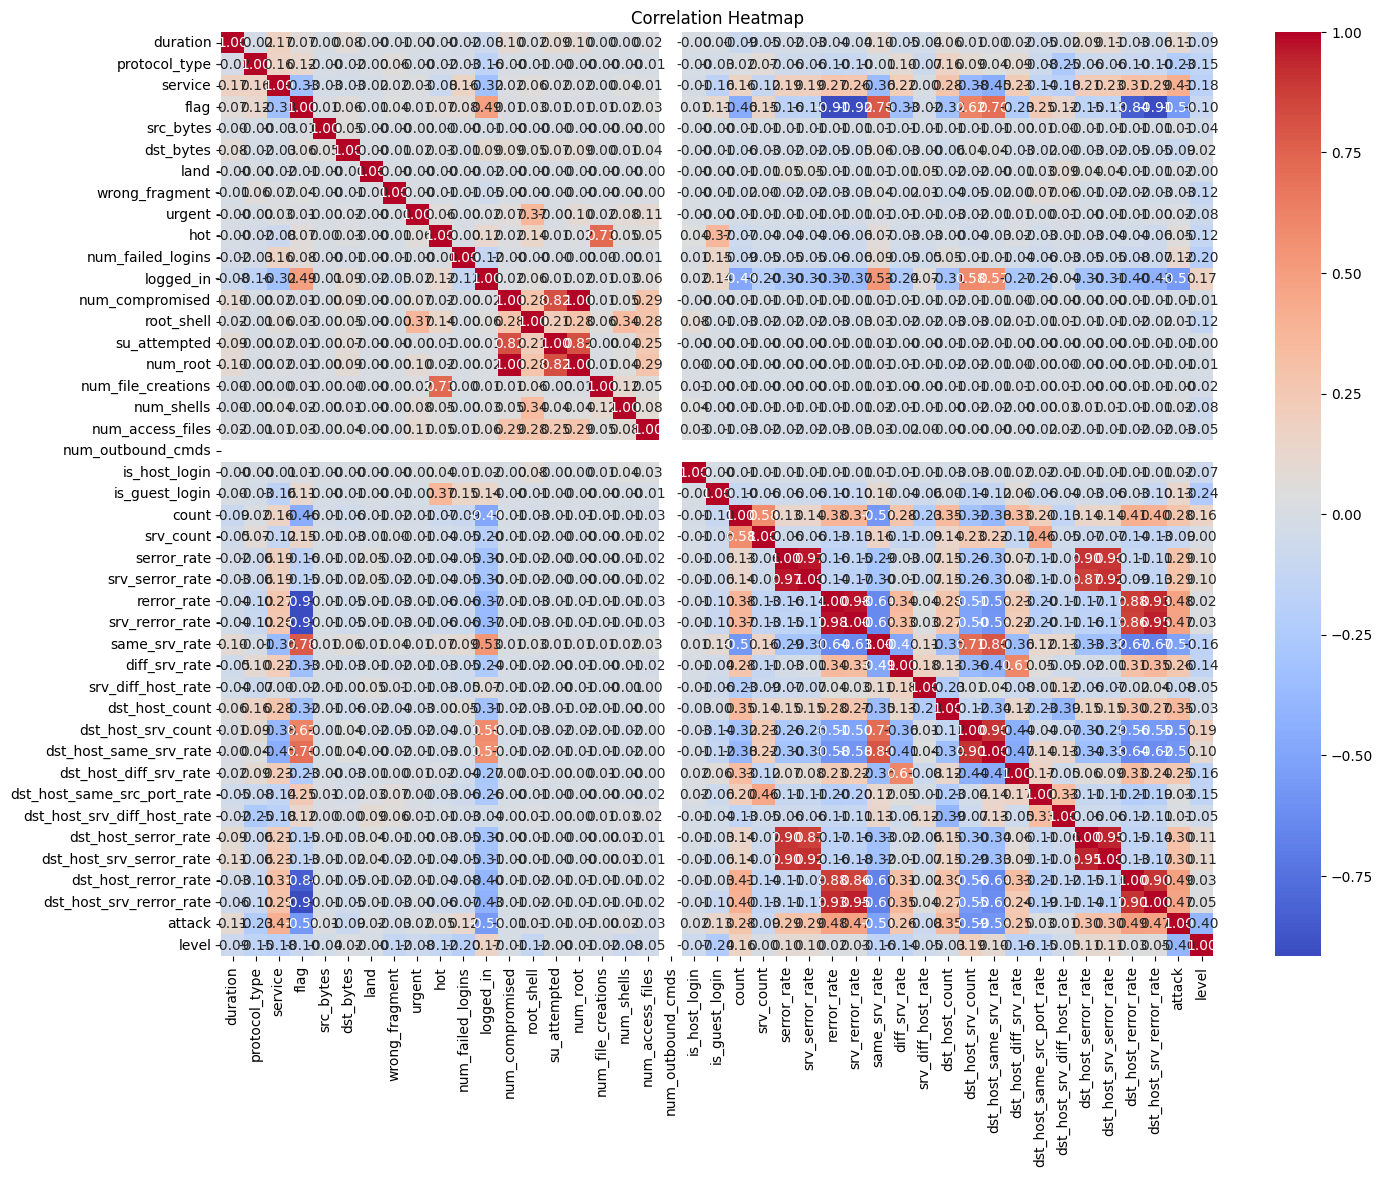

In [19]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


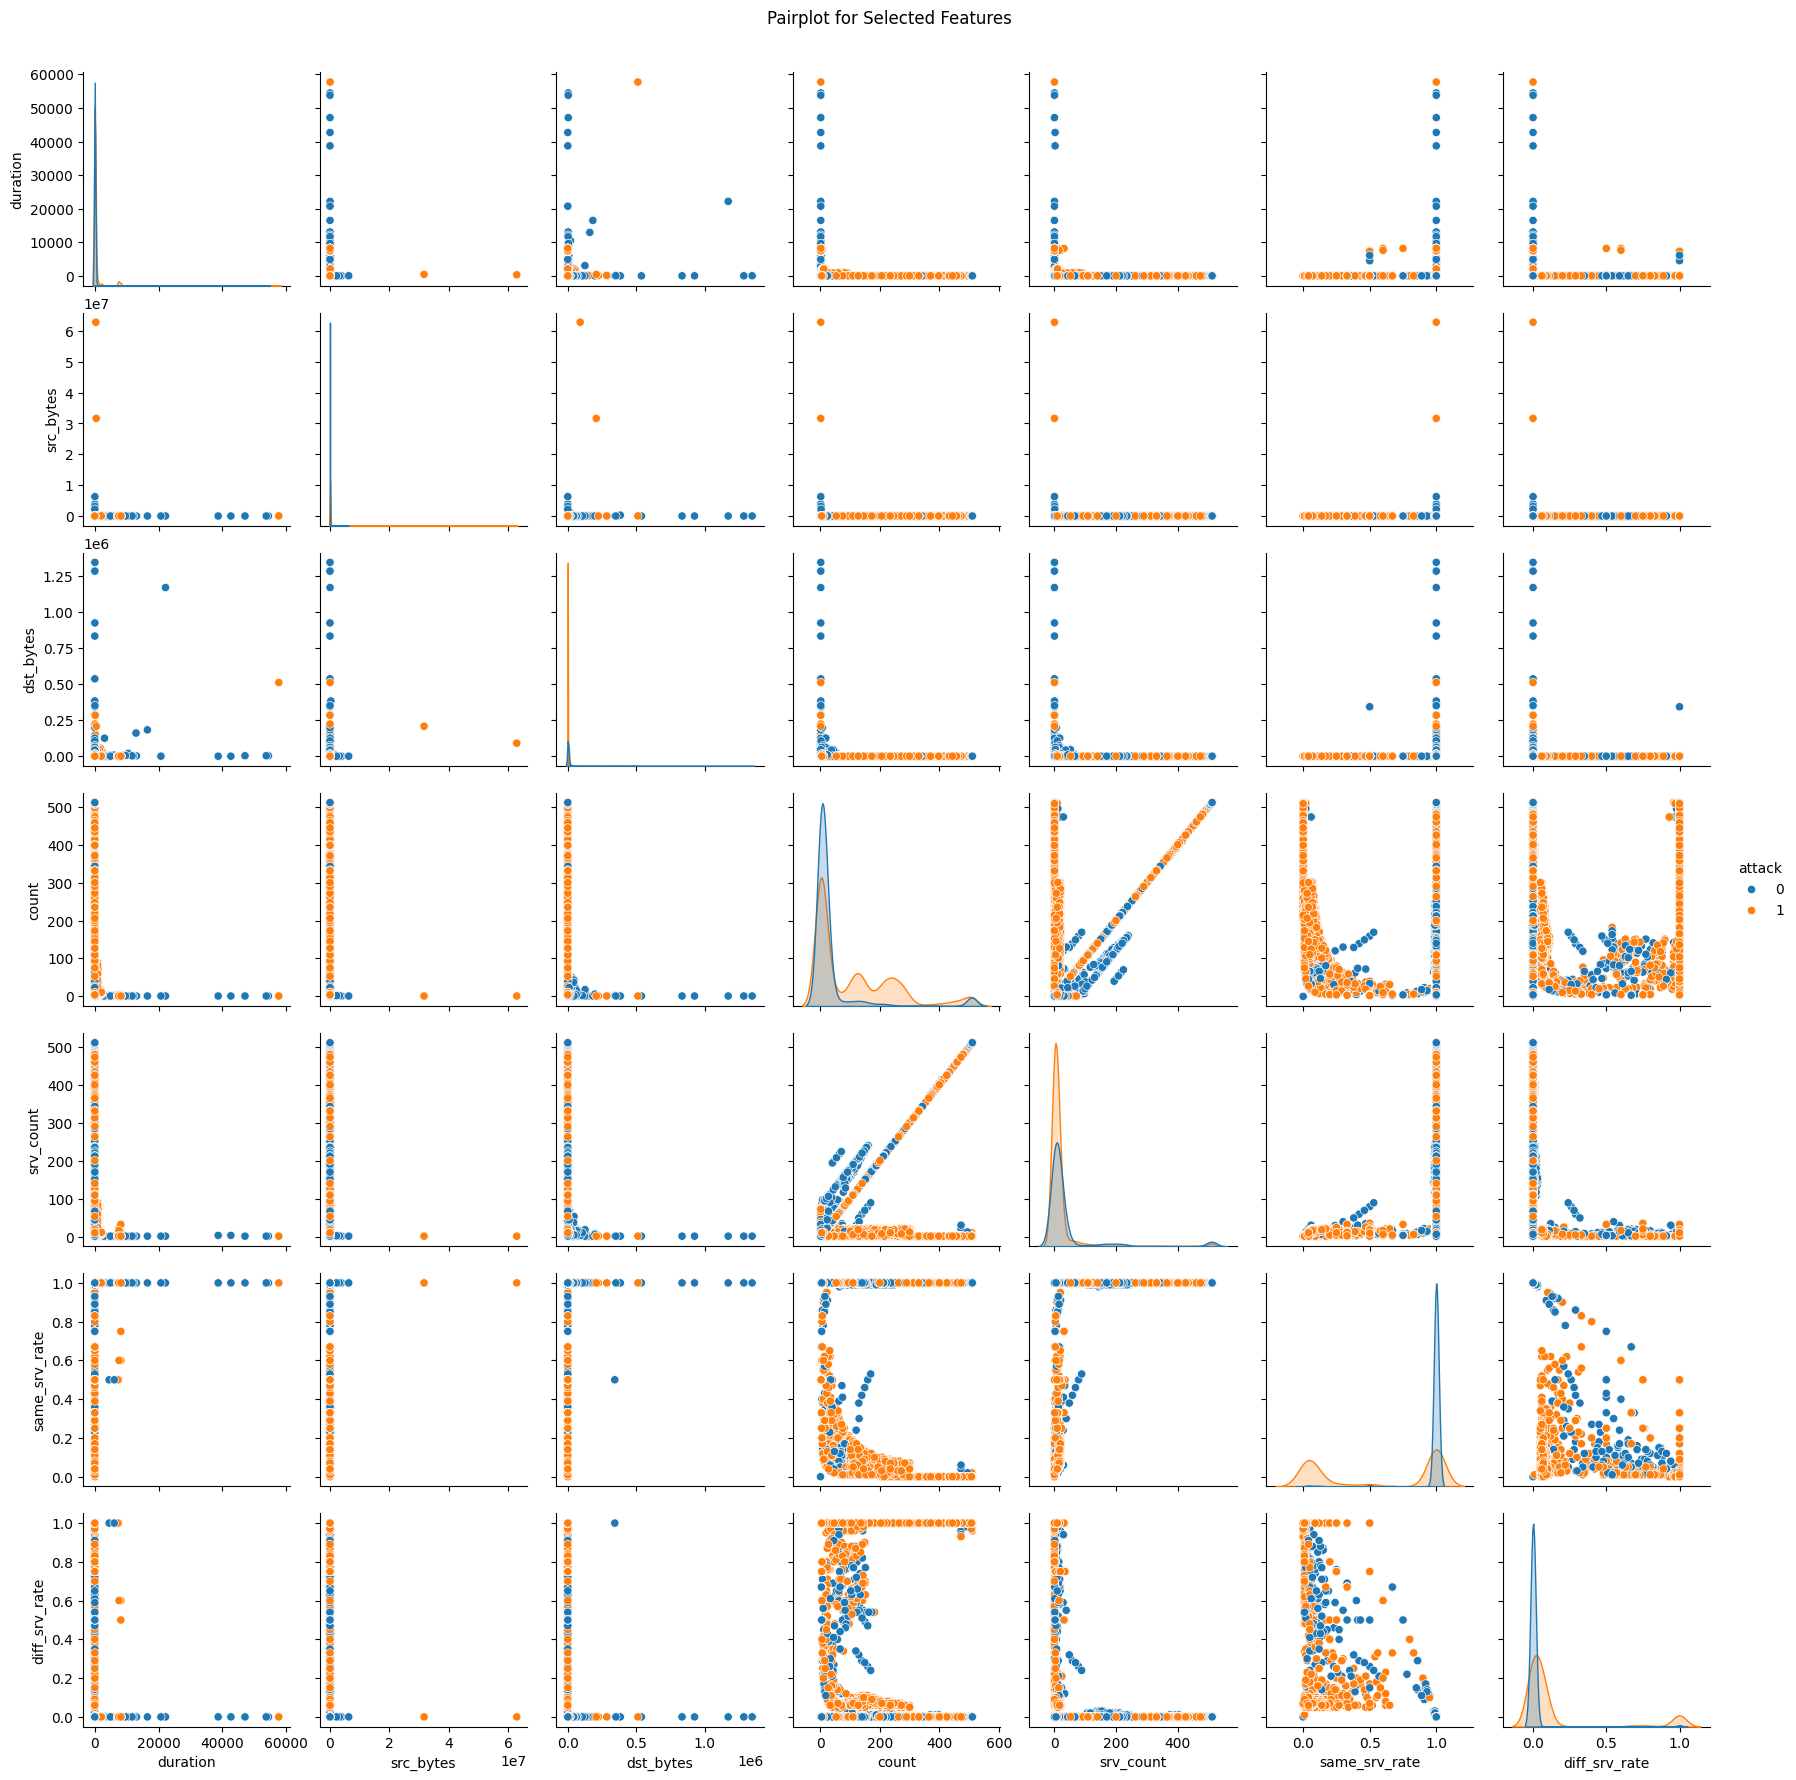

In [20]:
# Pairplot for selected features
selected_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'same_srv_rate', 'diff_srv_rate', 'attack']
sns.pairplot(data[selected_features], hue='attack', diag_kind='kde')
plt.suptitle('Pairplot for Selected Features', y=1.02)
plt.show()
